In [ ]:

# 12/10/2024

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
from scipy.stats import pointbiserialr

# airbnb = pd.read_csv("/content/Airbnb_Open_Data.csv", header=0)
airbnb = pd.read_csv("Airbnb.csv", header=0, low_memory=False) # load all the data in at once
airbnb.head(3)

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/21,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/22,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN


## **Data Cleaning**

In [ ]:

from Group1_Script import drop_cols
from Group1_Script import set_categories

# drop extra columns (create a subset)
columns = ['id', 'NAME', 'host name', 'host id', 'lat', 'long', 'country',
                         'calculated host listings count', 'country code', 'license']

df_subset = drop_cols(airbnb, columns)

# drop null values for important columns
df_subset = df_subset.dropna(subset=['Construction year', 'minimum nights', 'number of reviews', 'review rate number',
                                     'availability 365', 'last review', 'host_identity_verified'])

# set correct types
df_type_clean = df_subset.astype({'Construction year': 'int32',
                                  'minimum nights': 'int32',
                                  'number of reviews': 'int32',
                                  'review rate number': 'int32',
                                  'availability 365': 'int32'})


# Remove any non-numeric characters (e.g., $) and convert to float
df_type_clean['price'] = df_type_clean['price'].replace(r'[\$,]', '', regex=True).astype(float)
df_type_clean['service fee'] = df_type_clean['service fee'].replace(r'[\$,]', '', regex=True).astype(float)

# Fill with appropriate defaults
df_type_clean['reviews per month'] = df_type_clean['reviews per month'].fillna(0)

# Convert last review to a datetime object
df_type_clean['last review'] = pd.to_datetime(df_type_clean['last review'], format='%m/%d/%y',
                                              errors='coerce')

#Convert categorical columns (host_identity_verified, neighbourhood group, room type, etc.) to categories
categorical_columns = ['host_identity_verified', 'neighbourhood group', 'neighbourhood',
                       'instant_bookable', 'cancellation_policy', 'room type']

df_type_clean = set_categories(df_type_clean, categorical_columns)

# Clean up text columns like house_rules to remove extra spaces or inconsistent casing
df_type_clean['house_rules'] = df_type_clean['house_rules'].str.strip() # Clean up text columns like house_rules to remove extra spaces or inconsistent casing

#this was an excel error I believe --> wanted to get rid of it
df_type_clean['house_rules'] = df_type_clean['house_rules'].replace('#NAME?', np.nan)

# wanted to ensure that all of the prices had to be greater than 0
filter(df_type_clean, df_type_clean['price'] > 0)

# for many of the functions we use, we can't have any NaN values
# so, we will create this new Pandas DataFrame, but keep our old one for other analyis in case we need it
df_cleaned = df_type_clean.dropna()

# remove these data errors
if 'Hotel room' in df_cleaned['room type'].cat.categories:
    df_cleaned['room type'] = df_cleaned['room type'].cat.remove_categories('Hotel room')

if 'manhatan' in df_cleaned['neighbourhood group'].cat.categories:
    df_cleaned['neighbourhood group'] = df_cleaned['neighbourhood group'].cat.remove_categories('manhatan')

if 'brookln' in df_cleaned['neighbourhood group'].cat.categories:
    df_cleaned['neighbourhood group'] = df_cleaned['neighbourhood group'].cat.remove_categories('brookln')


/var/folders/vh/gp1_31tj6bl2hhnzmydx0s100000gn/T/ipykernel_63859/2130265831.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['room type'] = df_cleaned['room type'].cat.remove_categories('Hotel room')
/var/folders/vh/gp1_31tj6bl2hhnzmydx0s100000gn/T/ipykernel_63859/2130265831.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['neighbourhood group'] = df_cleaned['neighbourhood group'].cat.remove_categories('manhatan')
/var/folders/vh/gp1_31tj6bl2hhnzmydx0s100000gn/T/ipykernel_63859

# Question 1: How does the year of construction impact rental prices across different neighborhoods?


/var/folders/vh/gp1_31tj6bl2hhnzmydx0s100000gn/T/ipykernel_63859/1459799129.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_by_year_neighborhood = df_cleaned.groupby(['neighbourhood', 'Construction year'])['price'].mean().unstack()


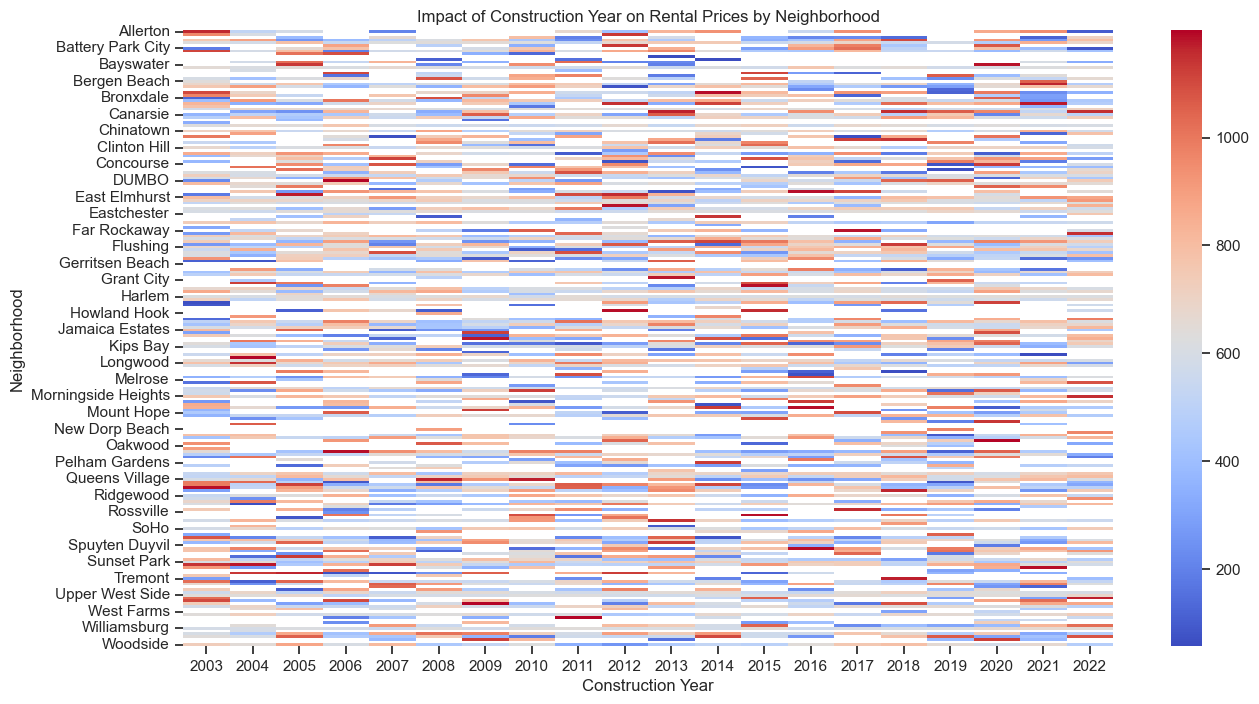

/var/folders/vh/gp1_31tj6bl2hhnzmydx0s100000gn/T/ipykernel_63859/1459799129.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Construction year'] = pd.to_numeric(df_cleaned['Construction year'], errors='coerce') # One more clean up to make sure that an error won't be thrown
/var/folders/vh/gp1_31tj6bl2hhnzmydx0s100000gn/T/ipykernel_63859/1459799129.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['price'] = pd.to_numeric(df_cleaned['price'], errors='coerce')# One more clean up 

Regression Coefficient: 0.09869167888714131 (Impact of Construction Year)
Intercept: 424.6300160088947
R-squared: 2.9042228244513524e-06


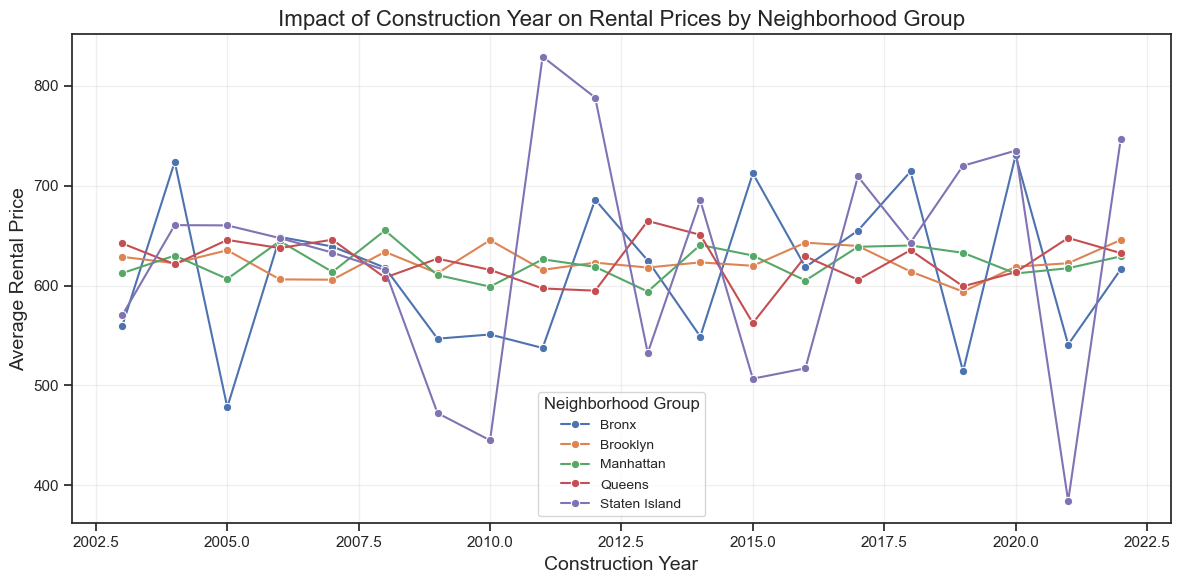

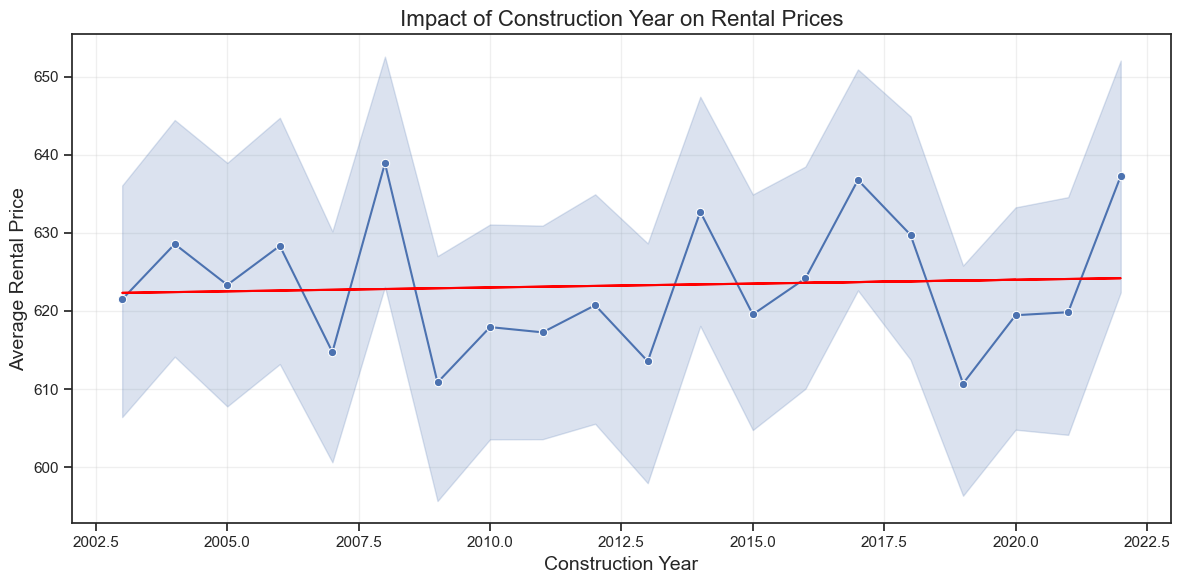

In [ ]:

# Question 1: How does the year of construction impact rental prices across different neighborhoods?
from Group1_Script import linear_reg

# Group by neighborhood and calculate mean price by construction year
price_by_year_neighborhood = df_cleaned.groupby(['neighbourhood', 'Construction year'])['price'].mean().unstack()

# Heatmap to visualize
plt.figure(figsize=(15, 8))
sns.heatmap(price_by_year_neighborhood, cmap='coolwarm', annot=False, cbar=True)
plt.title('Impact of Construction Year on Rental Prices by Neighborhood')
plt.xlabel('Construction Year')
plt.ylabel('Neighborhood')
plt.show()

# Linear regression model to quantify impact
X = df_cleaned[['Construction year']] # Predictor
y = df_cleaned['price'] # Target
reg = linear_reg(X, y)

print(f"Regression Coefficient: {reg.coef_[0]} (Impact of Construction Year)")
print(f"Intercept: {reg.intercept_}")
print(f"R-squared: {reg.score(X, y)}")

df_cleaned['Construction year'] = pd.to_numeric(df_cleaned['Construction year'], errors='coerce') # One more clean up to make sure that an error won't be thrown
df_cleaned['price'] = pd.to_numeric(df_cleaned['price'], errors='coerce')# One more clean up to make sure that an error won't be thrown
df_cleaned = df_cleaned.dropna() # extra check to make sure that there are no NaN values

# Filter for specific groups or aggregate
df_grouped = df_cleaned.groupby(['neighbourhood group', 'Construction year']).price.mean().reset_index()

# Plot average prices by neighborhood group and construction year
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_grouped,
    x='Construction year',
    y='price',
    hue='neighbourhood group',
    marker='o'
)
plt.title('Impact of Construction Year on Rental Prices by Neighborhood Group', fontsize=16)
plt.xlabel('Construction Year', fontsize=14)
plt.ylabel('Average Rental Price', fontsize=14)
plt.legend(title='Neighborhood Group', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Filter for specific groups or aggregate
x = df_cleaned['Construction year']
y = df_cleaned['price']
coefficients = np.polyfit(x, y, 1)  # 1 for linear, 2 for quadratic, etc.
trendline = np.poly1d(coefficients)

# Plot average prices by neighborhood group and construction year
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_cleaned,
    x='Construction year',
    y='price',
    marker='o'
)
plt.title('Impact of Construction Year on Rental Prices', fontsize=16)
plt.plot(x, trendline(x), color='red')
plt.xlabel('Construction Year', fontsize=14)
plt.ylabel('Average Rental Price', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Note for above --> R2 Value is very low**

Training R2: 0.8891
Test R2: 0.2762
                        Feature  Importance
0                         price    0.448782
1              availability 365    0.300060
2                minimum nights    0.128846
4        room type_Private room    0.024477
3     room type_Entire home/apt    0.024118
6  cancellation_policy_flexible    0.022765
7  cancellation_policy_moderate    0.022758
8    cancellation_policy_strict    0.022513
5         room type_Shared room    0.005682


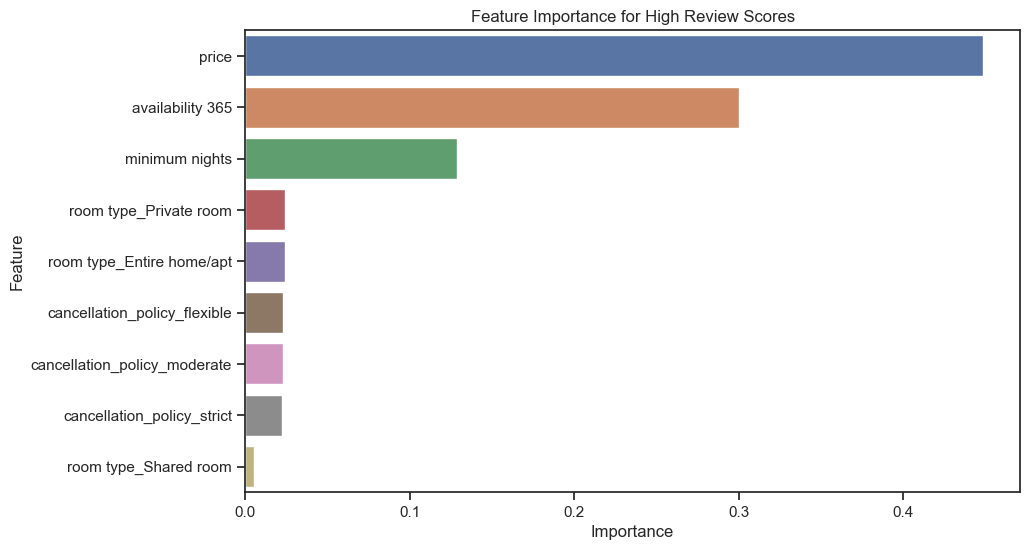

In [ ]:

# Question 2: Which listing characteristics within each neighborhood are associated with high review scores?

# Random forest to find important features
X = df_cleaned[['price', 'availability 365', 'minimum nights', 'room type', 'cancellation_policy']]
X = pd.get_dummies(X)  # One-hot encode categorical variables
y = df_cleaned['review rate number']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Getting R2 values
train_r2 = rf_model.score(X_train, y_train)  # R2 training data -- Fits training data
test_r2 = rf_model.score(X_test, y_test)  # R2 test data -- New, unseen data
print(f"Training R2: {train_r2:.4f}")
print(f"Test R2: {test_r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_}).sort_values(by='Importance', ascending=False)
print(feature_importance)

# Barplot of feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', hue='Feature', legend=False)
plt.title('Feature Importance for High Review Scores')
plt.show()

In [ ]:

# Linear regression model to quantify impact of price on review score
X = df_cleaned[['price']]  # Predictor
y = df_cleaned['review rate number'] # Target
reg1 = linear_reg(X, y)

print(f"Regression Coefficient: {reg1.coef_[0]} (Impact of Price)")
print(f"Intercept: {reg1.intercept_}")
print(f"R-squared: {reg1.score(X, y)}") # extremely low --> basically no linear impact

Regression Coefficient: -4.5861519483076246e-05 (Impact of Price)
Intercept: 3.2501955604801847
R-squared: 0.00013281028931566574


**Models for Below**

Point Biserial Correlation -->
Why it's a good fit: The Point Biserial correlation is specifically designed to measure the strength and direction of the relationship between one binary variable (host identity verification) and one continuous variable (review score).
How it works: This test will give you a correlation coefficient, which indicates the strength and direction of the relationship between the two variables.
A positive correlation means that verified hosts tend to have higher review scores.
A negative correlation means that verified hosts tend to have lower review scores.
A value near 0 suggests no significant correlation.

Linear Regression -->
Why it's a good fit: If you want to model the review score as a function of host verification status and potentially control for other variables (e.g., host location, number of reviews), linear regression would be a good option. You can use host verification as a binary predictor (coded as 0 for not verified, 1 for verified).
How it works: The regression model will estimate the expected difference in review scores between verified and unverified hosts, adjusting for any other factors you include in the model.
Interpretation: The coefficient for the verification variable will show how much the review score is expected to change when a host is verified.

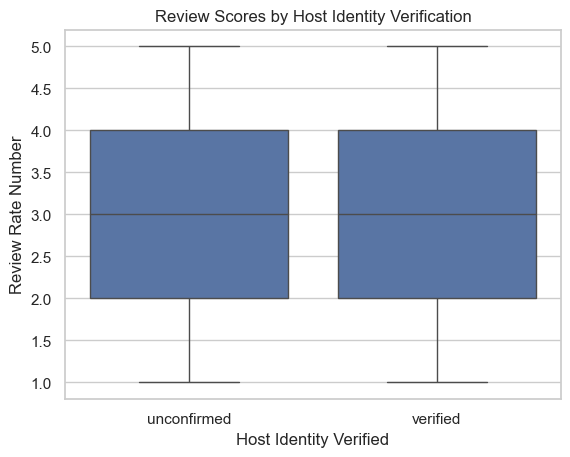

Point Biserial Correlation: 0.006093373168672173
P-value: 0.2344244054609039

Logistic Regression Coefficients:
{'host_identity_verified_verified': 0.030112869008035004, 'room type_Private room': 0.005551321303625407, 'room type_Shared room': -0.029216627672455458, 'neighbourhood group_Brooklyn': 0.03564743328877111, 'neighbourhood group_Manhattan': 0.04032464866605742, 'neighbourhood group_Queens': 0.03944581470957309, 'neighbourhood group_Staten Island': 0.117992138318543}

Classification Report:
              precision    recall  f1-score   support

           0       0.56      1.00      0.71     21142
           1       0.00      0.00      0.00     16938

    accuracy                           0.56     38080
   macro avg       0.28      0.50      0.36     38080
weighted avg       0.31      0.56      0.40     38080



/Users/thomaskantaros/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/thomaskantaros/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/thomaskantaros/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [ ]:

#Question 3: Is there a correlation between host identity being verified and the review score?

# Convert 'host_identity_verified' to binary (0 for 'unconfirmed', 1 for 'verified')
df_cleaned['host_identity_verified_binary'] = df_cleaned['host_identity_verified'].apply(lambda x: 1 if x == 'verified' else 0)

# Boxplot for EDA to visualize review scores by host identity verification
sns.boxplot(data=df_cleaned, x='host_identity_verified', y='review rate number')
plt.title('Review Scores by Host Identity Verification')
plt.xlabel('Host Identity Verified')
plt.ylabel('Review Rate Number')
plt.show()

# Point Biserial Correlation between host identity verification and review rate number
correlation, p_value = pointbiserialr(df_cleaned['host_identity_verified_binary'], df_cleaned['review rate number'])

print(f"Point Biserial Correlation: {correlation}")
print(f"P-value: {p_value}")
print()

# Logistic regression to predict high vs. low review score
df_cleaned['high_review'] = (df_cleaned['review rate number'] > df_cleaned['review rate number'].median()).astype(int)
X = pd.get_dummies(df_cleaned[['host_identity_verified', 'room type', 'neighbourhood group']], drop_first=True)
y = df_cleaned['high_review']

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X, y)

print("Logistic Regression Coefficients:")
print(dict(zip(X.columns, logreg.coef_[0])))
print()

print("Classification Report:")
y_pred = logreg.predict(X)
print(classification_report(y, y_pred))


**Interpretation of Results:**

1. Point Biserial Correlation:
Correlation value: 0.0060:
This value indicates a very weak positive correlation between host_identity_verified (binary: 1 for "verified" and 0 for "unconfirmed") and review rate number. The correlation is close to zero, suggesting that there is almost no linear relationship between whether the host identity is verified and the review score.
P-value: 0.23:
This p-value is greater than the typical threshold of 0.05, meaning the correlation is not statistically significant. Therefore, we fail to reject the null hypothesis, which suggests that the verification status of the host is unlikely to be meaningfully related to the review score.

2. Logistic Regression Coefficients:
The logistic regression model tries to predict whether a review is high (1) or low (0) based on various features, including host_identity_verified, room type, and neighbourhood group.
Coefficients:
host_identity_verified_verified: The coefficient is 0.0301, which means that when the host identity is verified (versus unverified), the log-odds of receiving a high review score (vs. low) increase by 0.0301. However, the effect is very small, and based on the correlation result, this may not be a significant predictor.
The coefficients for room type and neighbourhood group also indicate small changes in the log-odds of receiving a high review score.

3. Classification Report:
This report provides the performance metrics of the logistic regression model in predicting high vs. low review scores.
Precision, Recall, and F1-score for each class:

Class 0 (low review score):
Precision: 0.56: Among all instances predicted as class 0 (low review score), 56% were actually low review scores.
Recall: 1.00: Of all actual low review scores, the model identified 100% correctly.
F1-score: 0.71: A balanced score that takes both precision and recall into account for class 0.
Class 1 (high review score):
Precision: 0.00: The model predicted 0% of the actual high review scores as high.
Recall: 0.00: The model failed to identify any high review scores (all high review scores were missed).
F1-score: 0.00: The model's performance for predicting high review scores is extremely poor, as indicated by the F1-score of 0.00.
Overall Accuracy:

Accuracy: 56%: This is the percentage of correct predictions, but it is not a reliable metric here because of the class imbalance (much more data on low review scores than high review scores).
Macro and Weighted Averages:

Macro avg: The average performance across both classes, which is 0.28 for precision, 0.50 for recall, and 0.36 for F1.
Weighted avg: This takes into account the size of each class, and you see similar performance with 0.31 precision, 0.56 recall, and 0.40 F1.

Key Takeaways:
Point Biserial Correlation indicates no meaningful linear relationship between host identity verification and review scores.
Logistic Regression has a poor ability to predict high vs. low review scores. While it performs well at predicting low review scores (class 0), it fails to predict high review scores (class 1). This is likely due to an imbalance in the classes (more low scores than high).
The model struggles to identify high review scores, and this is reflected in the Precision and Recall being 0 for class 1.

/var/folders/vh/gp1_31tj6bl2hhnzmydx0s100000gn/T/ipykernel_63859/3725682821.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  occupancy_by_room_neighborhood = df_cleaned.groupby(['neighbourhood', 'room type'])['occupancy_rate'].mean().unstack()


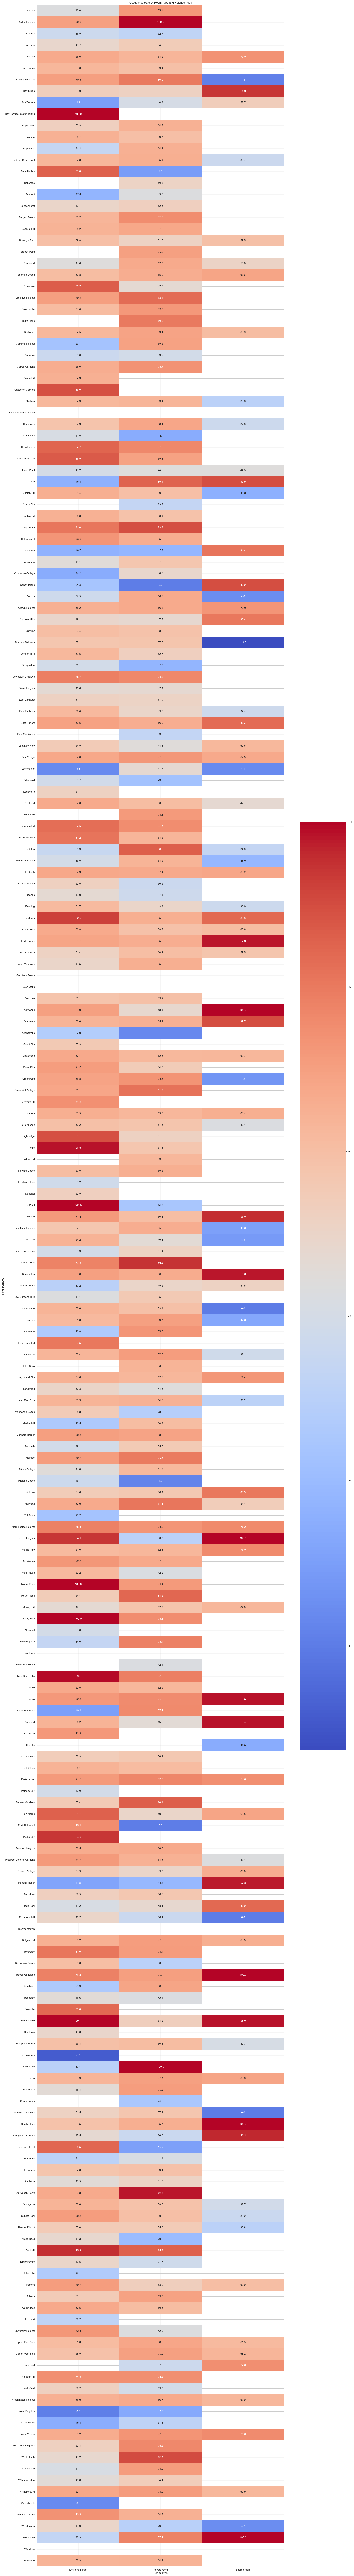

In [ ]:

# Question 4 (initial): Which room types have the highest occupancy rate, and in which neighborhoods?
# Note --> output too large, changed question in next code block

# Calculate occupancy rate
df_cleaned['occupancy_rate'] = (365 - df_cleaned['availability 365']) / 365 * 100

# Group by room type and neighborhood
occupancy_by_room_neighborhood = df_cleaned.groupby(['neighbourhood', 'room type'])['occupancy_rate'].mean().unstack()

# Heatmap for visualization
plt.figure(figsize=(24, 200))
sns.heatmap(occupancy_by_room_neighborhood, cmap='coolwarm', annot=True, fmt=".1f")
plt.title('Occupancy Rate by Room Type and Neighborhood')
plt.xlabel('Room Type')
plt.ylabel('Neighborhood')
plt.show()

/var/folders/vh/gp1_31tj6bl2hhnzmydx0s100000gn/T/ipykernel_63859/558304299.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  occupancy_by_room_neighborhood = df_cleaned.groupby(['neighbourhood group', 'room type'])['occupancy_rate'].mean().unstack()


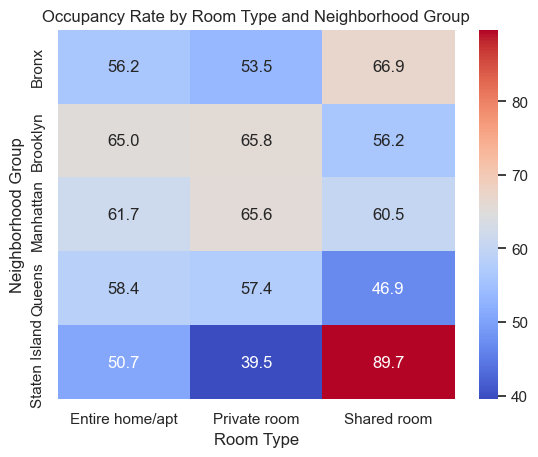

In [ ]:

#Question 4 (changed): Which room types have the highest occupancy rate, and in which neighborhoods?

# Calculate occupancy rate
df_cleaned['occupancy_rate'] = (365 - df_cleaned['availability 365']) / 365 * 100

# Group by room type and neighborhood
occupancy_by_room_neighborhood = df_cleaned.groupby(['neighbourhood group', 'room type'])['occupancy_rate'].mean().unstack()

# Heatmap for visualization
# plt.figure(figsize=(24, 200))
sns.heatmap(occupancy_by_room_neighborhood, cmap='coolwarm', annot=True, fmt=".1f")
plt.title('Occupancy Rate by Room Type and Neighborhood Group')
plt.xlabel('Room Type')
plt.ylabel('Neighborhood Group')
plt.show()

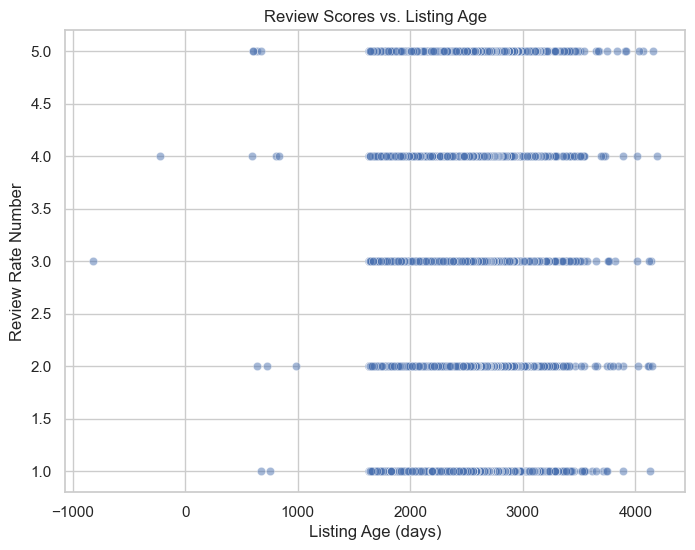

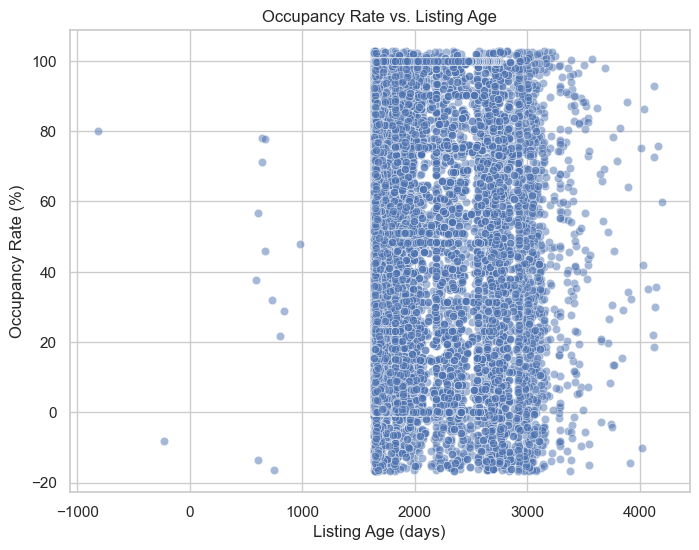

Impact of Listing Age on Review Scores: -0.00028364265624824066
Impact of Listing Age on Occupancy Rate: 0.0034342700306997736


In [ ]:

#Question 5: How does the age of the listing affect review scores or occupancy rates?\
# Calculate listing age
df_cleaned['listing_age'] = (pd.to_datetime('2024-01-01') - df_cleaned['last review']).dt.days

# Scatterplot for listing age vs. review scores
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cleaned, x='listing_age', y='review rate number', alpha=0.5)
plt.title('Review Scores vs. Listing Age')
plt.xlabel('Listing Age (days)')
plt.ylabel('Review Rate Number')
plt.show()

# Scatterplot for listing age vs. occupancy rate
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cleaned, x='listing_age', y='occupancy_rate', alpha=0.5)
plt.title('Occupancy Rate vs. Listing Age')
plt.xlabel('Listing Age (days)')
plt.ylabel('Occupancy Rate (%)')
plt.show()

# Linear regression for quantitative analysis
X = df_cleaned[['listing_age']]
y_reviews = df_cleaned['review rate number']
y_occupancy = df_cleaned['occupancy_rate']

reg_reviews = linear_reg(X, y_reviews)
reg_occupancy = linear_reg(X, y_occupancy)

print(f"Impact of Listing Age on Review Scores: {reg_reviews.coef_[0]}")
print(f"Impact of Listing Age on Occupancy Rate: {reg_occupancy.coef_[0]}")


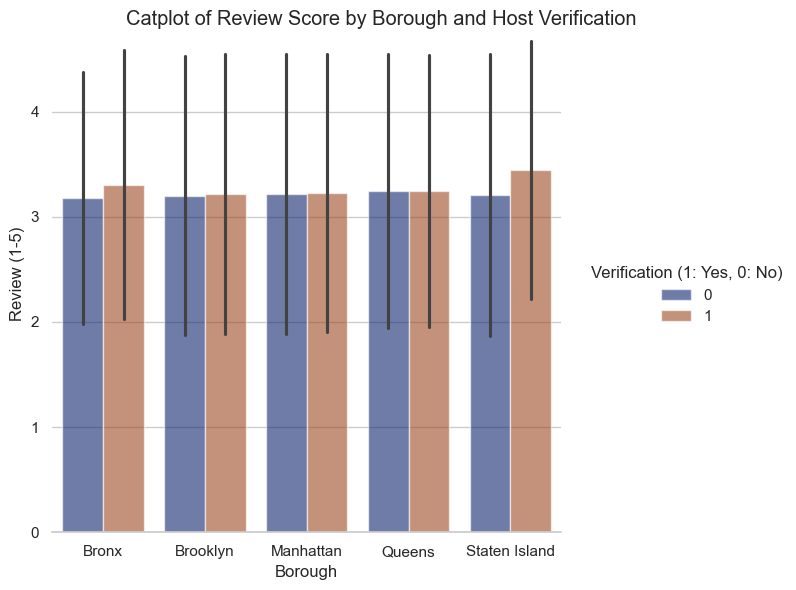

In [ ]:

sns.set_theme(style="whitegrid")

# Draw a catplot by neighbourhood group and verification
g = sns.catplot(
    data=df_cleaned, kind="bar",
    x="neighbourhood group", y="review rate number", hue="host_identity_verified_binary",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Borough", "Review (1-5)")
g.fig.suptitle("Catplot of Review Score by Borough and Host Verification")
g.legend.set_title("Verification (1: Yes, 0: No)")

**The graph above will be a part of our exploratory data analysis: the review score does not seem be impacted by the verification...**

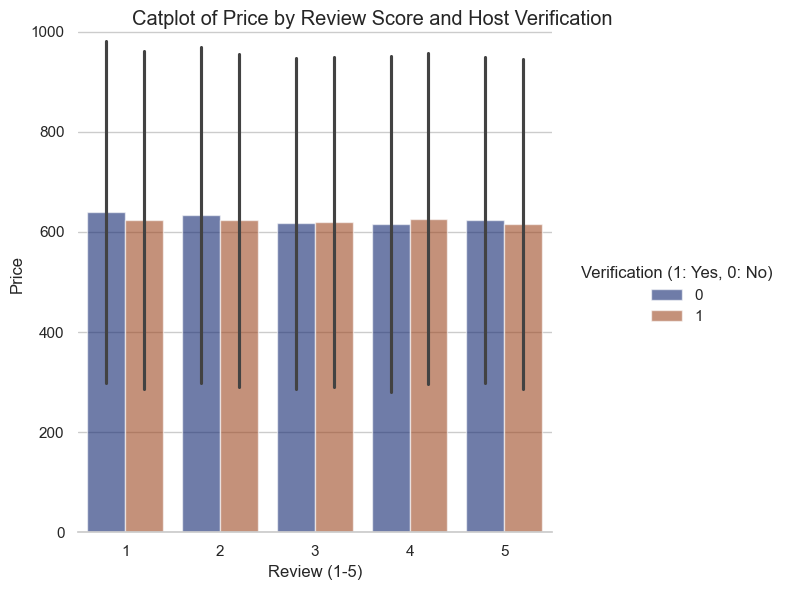

In [ ]:

sns.set_theme(style="whitegrid")

# Draw a catplot by neighbourhood group and verification
g = sns.catplot(
    data=df_cleaned, kind="bar",
    x="review rate number", y="price", hue="host_identity_verified_binary",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Review (1-5)", "Price")
g.fig.suptitle("Catplot of Price by Review Score and Host Verification")
g.legend.set_title("Verification (1: Yes, 0: No)")

**Need to look at further --> doesn't look like different review scores are asssociated to different prices, but I don't know... would that mean our model is wrong?**


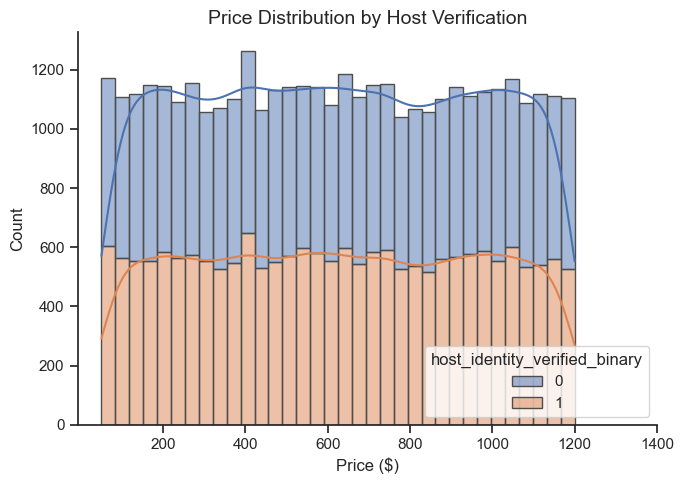

In [ ]:

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

sns.histplot(
    df_cleaned,
    x="price", hue="host_identity_verified_binary",
    kde = True,
    multiple="stack",
    # palette="light:m_r",
    edgecolor=".3",
    # linewidth=.5,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([200, 400, 600, 800, 1000, 1200, 1400])

ax.set_xlabel("Price ($)")
ax.set_ylabel("Count")
ax.set_title("Price Distribution by Host Verification", fontsize=14)

plt.tight_layout()

**Still working on the legend to make it as my one before --> cool to see here that price is pretty evenly distributed, so if we get results about price, we know they are able to be confirmed**

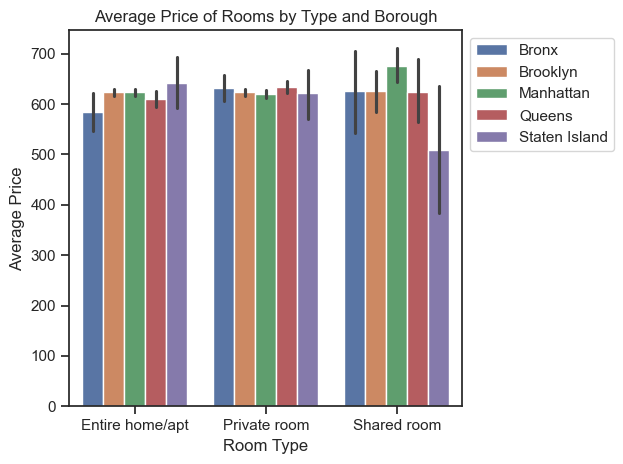

In [ ]:

ax = sns.barplot(df_cleaned, x = "room type", y = "price", hue = "neighbourhood group")

plt.title("Average Price of Rooms by Type and Borough")
plt.xlabel("Room Type")
plt.ylabel("Average Price")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # (1, 1) places it outside the plot just right
plt.tight_layout()

**exploratory data analysis on room type ^^**

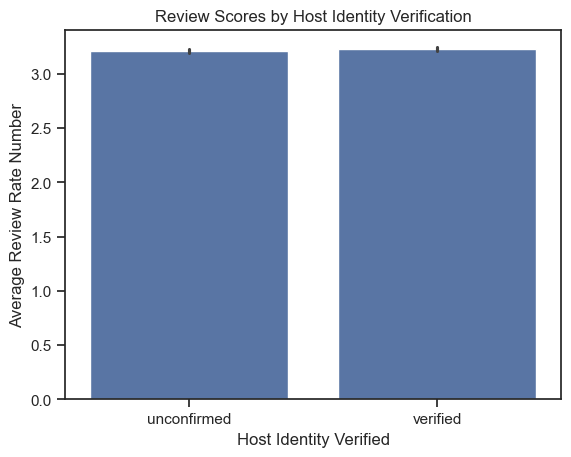

In [ ]:

# compare boxplot above with a barplot
sns.barplot(df_cleaned, x = "host_identity_verified", y = "review rate number")
plt.title('Review Scores by Host Identity Verification')
plt.xlabel('Host Identity Verified')
plt.ylabel('Average Review Rate Number')
plt.show()

/var/folders/vh/gp1_31tj6bl2hhnzmydx0s100000gn/T/ipykernel_63859/2370198387.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_price_by_neighbourhood = df_cleaned.groupby('neighbourhood')['price'].median().sort_values(ascending=False)


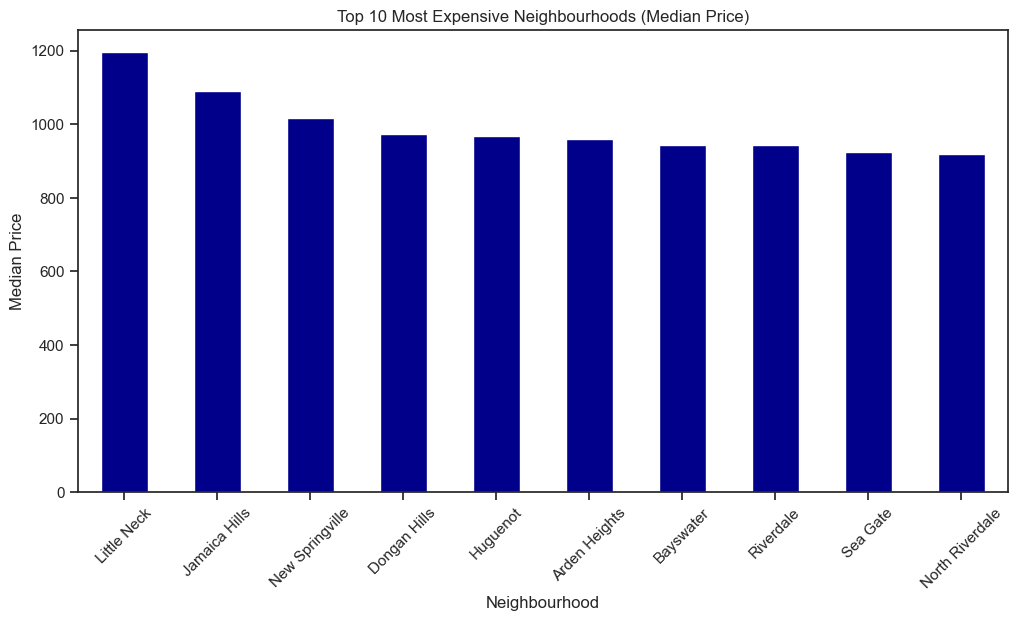

In [ ]:
# 
if 'neighbourhood' in df_cleaned.columns and 'price' in df_cleaned.columns:
  median_price_by_neighbourhood = df_cleaned.groupby('neighbourhood')['price'].median().sort_values(ascending=False)

  # Top 10 most expensive neighborhoods
  plt.figure(figsize=(12, 6))
  median_price_by_neighbourhood.head(10).plot(kind='bar', color='darkblue')
  plt.title("Top 10 Most Expensive Neighbourhoods (Median Price)")
  plt.xlabel("Neighbourhood")
  plt.ylabel("Median Price")
  plt.xticks(rotation=45)
  plt.show()


In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
from scipy.stats import pointbiserialr

airbnb = pd.read_csv("Airbnb.csv", header=0, low_memory=False) # load all the data in at once
# airbnb = pd.read_csv("/content/Airbnb_Open_Data.csv", header=0)
airbnb.head()
df_subset = airbnb.drop(['id', 'NAME', 'neighbourhood', 'house_rules', 'host name', 'host id', 'lat', 'long', 'country',
                         'calculated host listings count', 'country code', 'license'], axis=1)
df_subset.head()


print(df_subset.dtypes) # checked to see types --> a few that should be int are float

df_subset = df_subset.dropna(subset=['Construction year', 'minimum nights', 'number of reviews', 'review rate number', 'availability 365'])

df_type_clean = df_subset.astype({'Construction year': 'int32',
                                  'minimum nights': 'int32',
                                  'number of reviews': 'int32',
                                  'review rate number': 'int32',
                                  'availability 365': 'int32'})

print(df_type_clean.dtypes)
# Remove any non-numeric characters (e.g., $) and convert to float
df_type_clean['price'] = df_type_clean['price'].replace('[\$,]', '', regex=True).astype(float)
df_type_clean['service fee'] = df_type_clean['service fee'].replace('[\$,]', '', regex=True).astype(float)

df_type_clean['reviews per month'] = df_type_clean['reviews per month'].fillna(0) # Fill with appropriate defaults
df_type_clean = df_type_clean.dropna(subset=['last review', 'host_identity_verified']) # Drop rows with critical missing data

df_type_clean['last review'] = pd.to_datetime(df_type_clean['last review'], errors='coerce') #Convert last review to a datetime object

#Convert categorical columns (host_identity_verified, neighbourhood group, room type, etc.) to category
categorical_columns = ['host_identity_verified', 'neighbourhood group', 'instant_bookable', 'cancellation_policy', 'room type']
for col in categorical_columns:
    df_type_clean[col] = df_type_clean[col].astype('category')

#df_type_clean['house_rules'] = df_type_clean['house_rules'].str.strip() #Clean up text columns like house_rules to remove extra spaces or inconsistent casing
#df_type_clean['house_rules'] = df_type_clean['house_rules'].replace('#NAME?', np.nan) #this was an excel error I believe --> wanted to get rid of it

print(df_type_clean.info())
print(df_type_clean.describe(include='all'))
# wanted to ensure that all of the prices had to be greater than 0
filter(df_type_clean, df_type_clean['price'] > 0)
print(df_type_clean['price'].min())
# for a few of the built-in functions, we can't have any NaN values
# so, we will create this new Pandas DataFrame, but keep our old one for other analyis
df_cleaned = df_type_clean.dropna()


# Load data
data = df_cleaned
data['host_identity_verified'] = data['host_identity_verified'].astype(str)
data['host_identity_verified'] = data['host_identity_verified'].map(
    {'unconfirmed': 0, 'verified': 1, '0': 0, '1': 1})


# One-hot encode 'neighbourhood group' and 'room type'
#data = pd.get_dummies(data, columns=['neighbourhood group', 'room type', 'cancellation_policy'], drop_first=True)
data['cancellation_policy'] = data['cancellation_policy'].astype(str)
cancellation_policy_mapping = {'strict': 0, 'moderate': 1, 'flexible': 2}
data['cancellation_policy'] = data['cancellation_policy'].map(cancellation_policy_mapping)

data = pd.get_dummies(data, columns=['neighbourhood group', 'room type', 'instant_bookable'], drop_first=True)

# 4. Handle the 'last review' column (extract year and month)
data['last_review'] = pd.to_datetime(data['last review'], errors='coerce')
data['review_year'] = data['last_review'].dt.year
data['review_month'] = data['last_review'].dt.month
data.drop(['last review'], axis=1, inplace=True)
print(data.dtypes)

<>:40: SyntaxWarning: invalid escape sequence '\$'
<>:41: SyntaxWarning: invalid escape sequence '\$'
<>:40: SyntaxWarning: invalid escape sequence '\$'
<>:41: SyntaxWarning: invalid escape sequence '\$'
/var/folders/vh/gp1_31tj6bl2hhnzmydx0s100000gn/T/ipykernel_63859/2171101795.py:40: SyntaxWarning: invalid escape sequence '\$'
  df_type_clean['price'] = df_type_clean['price'].replace('[\$,]', '', regex=True).astype(float)
/var/folders/vh/gp1_31tj6bl2hhnzmydx0s100000gn/T/ipykernel_63859/2171101795.py:41: SyntaxWarning: invalid escape sequence '\$'
  df_type_clean['service fee'] = df_type_clean['service fee'].replace('[\$,]', '', regex=True).astype(float)


host_identity_verified     object
neighbourhood group        object
instant_bookable           object
cancellation_policy        object
room type                  object
Construction year         float64
price                      object
service fee                object
minimum nights            float64
number of reviews         float64
last review                object
reviews per month         float64
review rate number        float64
availability 365          float64
dtype: object
host_identity_verified     object
neighbourhood group        object
instant_bookable           object
cancellation_policy        object
room type                  object
Construction year           int32
price                      object
service fee                object
minimum nights              int32
number of reviews           int32
last review                object
reviews per month         float64
review rate number          int32
availability 365            int32
dtype: object
<class 'pandas.core.

/var/folders/vh/gp1_31tj6bl2hhnzmydx0s100000gn/T/ipykernel_63859/2171101795.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_type_clean['last review'] = pd.to_datetime(df_type_clean['last review'], errors='coerce') #Convert last review to a datetime object
/var/folders/vh/gp1_31tj6bl2hhnzmydx0s100000gn/T/ipykernel_63859/2171101795.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['host_identity_verified'] = data['host_identity_verified'].astype(str)
/var/folders/vh/gp1_31tj6bl2hhnzmydx0s100000gn/T/ipykernel_63859/2171101795.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [ ]:
#Shivam
#do not edit
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import shap
import lightgbm as lgb
from sklearn.inspection import permutation_importance




# Preprocessing: Transform the dataset
# Ensure datetime is converted to numeric and drop non-numeric columns
data['days_since_last_review'] = (pd.to_datetime('today') - data['last_review']).dt.days
data.drop(columns=[ 'last_review','predicted_price', 'price_category'], inplace=True, errors='ignore')  # Drop non-numeric columns
bool_columns = data.select_dtypes(include='bool').columns
data[bool_columns] = data[bool_columns].astype(int)

# Check for non-numeric columns
non_numeric_cols = data.select_dtypes(include=['object']).columns
print(f"Non-numeric columns: {list(non_numeric_cols)}")  # Ensure no strings remain
assert len(non_numeric_cols) == 0, "Dataset contains non-numeric columns!"

# Separate features and target variable
X = data.drop(columns=['price','service fee'])
y = data['price']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Importance (Dependency)
mutual_info = mutual_info_regression(X_train, y_train, random_state=42)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': mutual_info
}).sort_values(by='Importance', ascending=False)
print("Feature Importance:\n", feature_importance)

# Train a Regression Model
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Predict prices
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Model Evaluation:\nMSE: {mse}\nR²: {r2}")

# Predict prices for the entire dataset
data['predicted_price'] = model.predict(X)

# Categorize price (Define thresholds based on your use case)
def categorize_price(row):
    if row['price'] > row['predicted_price'] * 1.2:  # Overpriced if actual > 20% above predicted
        return "Overpriced"
    elif row['price'] < row['predicted_price'] * 0.8:  # Good bargain if actual < 20% below predicted
        return "Good Bargain"
    else:
        return "Fair Price"

data['price_category'] = data.apply(categorize_price, axis=1)

print(data[['price', 'predicted_price', 'price_category']].head())

from sklearn.metrics import accuracy_score

# Assuming you have the true labels and predicted labels
y_true = data['price_category']  # True price categories (from the original data)
y_pred = model.predict(X_test)  # Predicted price categories



# Results

In [ ]:
y_true = y_test  # Actual prices from the test set
y_pred = model.predict(X_test)  # Predicted prices from the test set

# Ensure y_pred is a 1D array if needed
y_pred = y_pred.flatten()

# Now calculate the evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

r_squared = r2_score(y_true, y_pred)
print(f"R-squared (R²): {r_squared:.4f}")

Mean Absolute Error (MAE): 222.8323
Mean Squared Error (MSE): 75850.9554
Root Mean Squared Error (RMSE): 275.4105
R-squared (R²): 0.3129


In [ ]:
#Shivam
#do not edit
# Decode neighborhood group
data['neighbourhood_group'] = data[['neighbourhood group_Brooklyn',
                                    'neighbourhood group_Manhattan',
                                    'neighbourhood group_Queens',
                                    'neighbourhood group_Staten Island',
                                    'neighbourhood group_brookln',
                                    'neighbourhood group_manhatan']].idxmax(axis=1)
data['neighbourhood_group'] = data['neighbourhood_group'].str.replace('neighbourhood group_', '')

# Decode room type
data['room_type'] = data[['room type_Hotel room',
                          'room type_Private room',
                          'room type_Shared room']].idxmax(axis=1)
data['room_type'] = data['room_type'].str.replace('room type_', '')

# Decode instant_bookable
data['instant_bookable'] = data['instant_bookable_True'].replace({True: 'Yes', False: 'No'})

# Drop the boolean columns now that we've created categorical ones
boolean_cols = ['neighbourhood group_Brooklyn', 'neighbourhood group_Manhattan',
                'neighbourhood group_Queens', 'neighbourhood group_Staten Island',
                'neighbourhood group_brookln', 'neighbourhood group_manhatan',
                'room type_Hotel room', 'room type_Private room', 'room type_Shared room',
                'instant_bookable_True']
data = data.drop(columns=boolean_cols)

# Display the first few rows of the dataset
data

,host_identity_verified,cancellation_policy,Construction year,price,service fee,minimum nights,number of reviews,reviews per month,review rate number,availability 365,review_year,review_month,days_since_last_review,predicted_price,price_category,neighbourhood_group,room_type,instant_bookable
0,0,0,2020,966.0,193.0,10,9,0.21,4,286,2021,10,1148,795.13,Overpriced,Brooklyn,Private room,0
1,1,1,2007,142.0,28.0,30,45,0.38,4,228,2022,5,934,319.44,Good Bargain,Manhattan,Hotel room,0
3,0,1,2005,368.0,74.0,30,270,4.64,4,322,2019,7,1985,456.19,Fair Price,Brooklyn,Hotel room,1
4,1,1,2009,204.0,41.0,10,9,0.10,3,289,2018,11,2213,358.39,Good Bargain,Manhattan,Hotel room,0
5,1,2,2013,577.0,115.0,3,74,0.59,3,374,2019,6,1998,599.20,Fair Price,Manhattan,Hotel room,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102588,0,2,2016,618.0,124.0,1,177,3.78,4,410,2019,6,1991,611.20,Fair Price,Manhattan,Hotel room,1
102591,1,0,2005,1139.0,228.0,5,17,0.35,5,134,2019,1,2167,1087.17,Fair Price,Manhattan,Hotel room,0
102593,1,0,2017,1099.0,220.0,1,8,0.16,4,152,2015,9,3383,1038.44,Fair Price,Manhattan,Private room,1
102595,0,1,2016,837.0,167.0,1,1,0.02,2,395,2015,7,3445,802.41,Fair Price,Manhattan,Private room,1


<ipython-input-44-e3fb3bcc7be4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='price_category', data=data, palette='Set2')


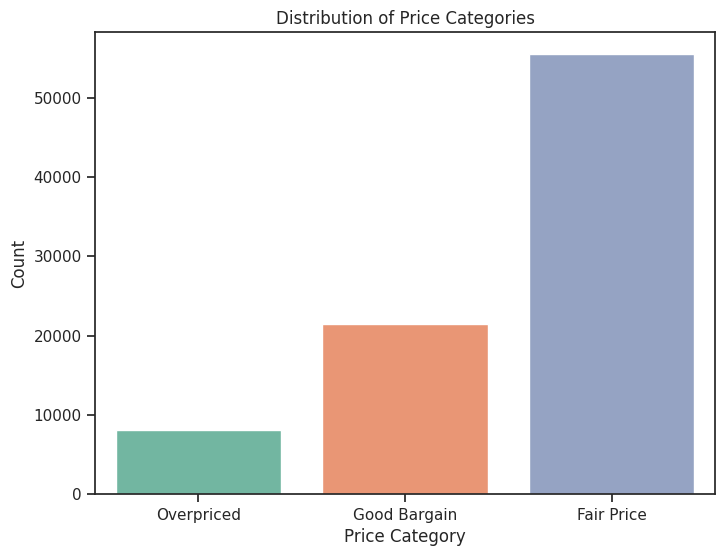

<ipython-input-44-e3fb3bcc7be4>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_category', y='price', data=data, palette='Set2')


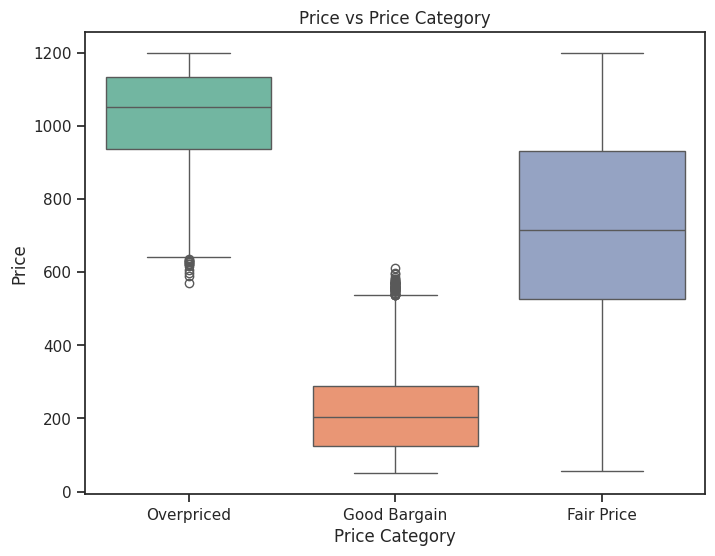

<ipython-input-44-e3fb3bcc7be4>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='neighbourhood_group', y='price', data=data, palette='Set2')


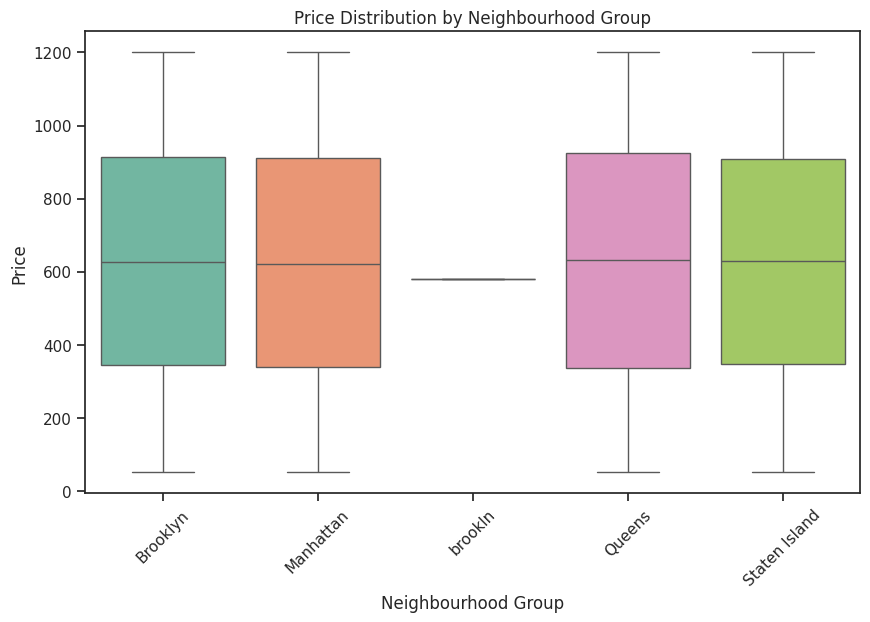

<ipython-input-44-e3fb3bcc7be4>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='room_type', y='price', data=data, palette='Set2')


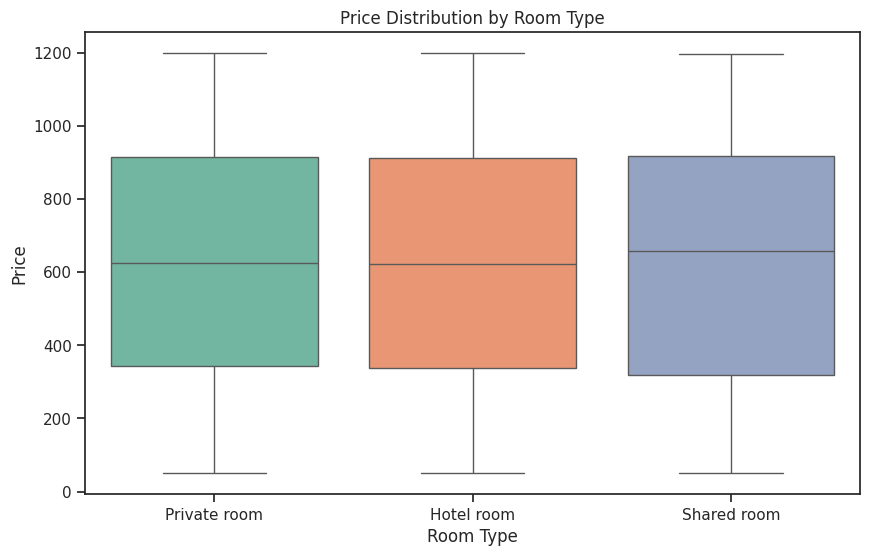

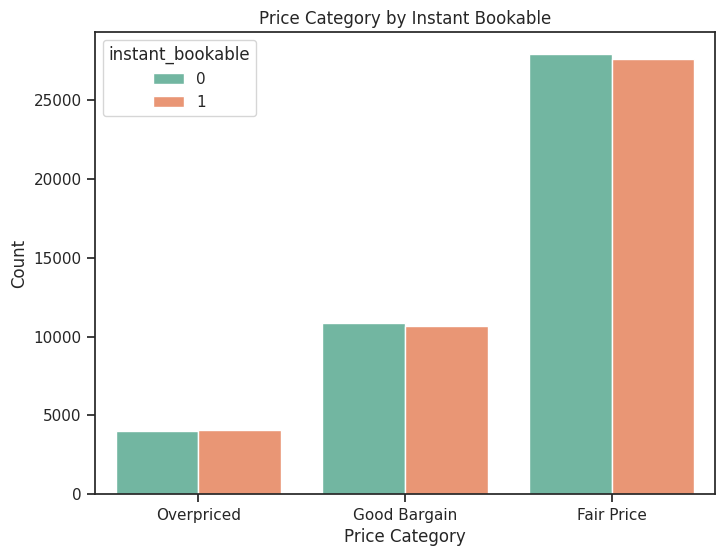

<ipython-input-44-e3fb3bcc7be4>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_category', y='days_since_last_review', data=data, palette='Set2')


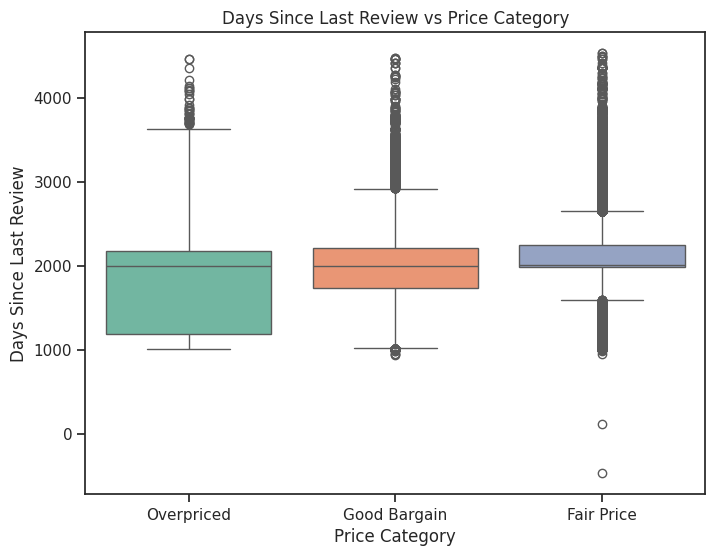

<ipython-input-44-e3fb3bcc7be4>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_category', y='reviews per month', data=data, palette='Set2')


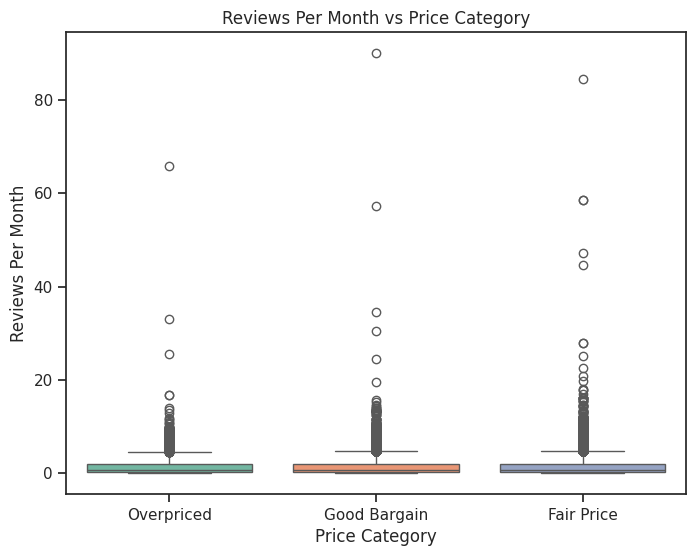

<ipython-input-44-e3fb3bcc7be4>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_category', y='availability 365', data=data, palette='Set2')


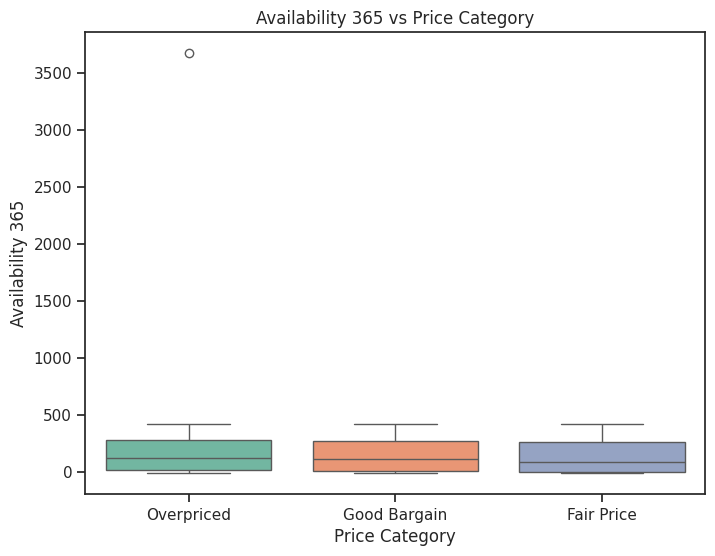

<ipython-input-44-e3fb3bcc7be4>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_category', y='number of reviews', data=data, palette='Set2')


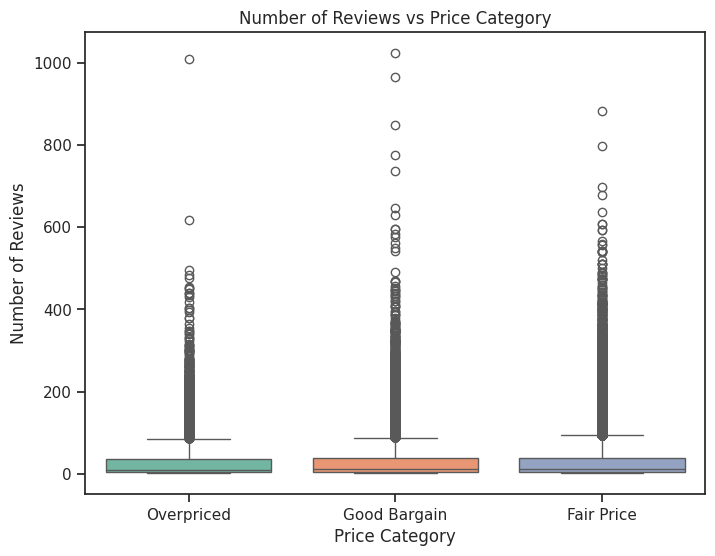

<ipython-input-44-e3fb3bcc7be4>:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_category', y='Construction year', data=data, palette='Set2')


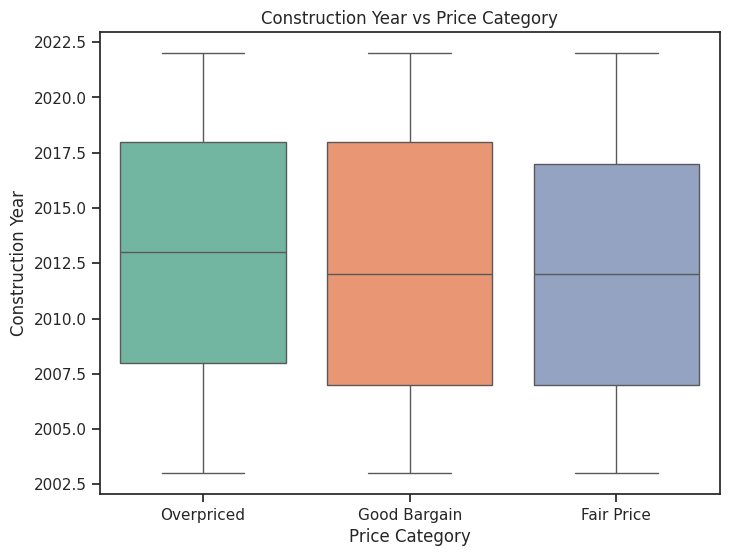

<ipython-input-44-e3fb3bcc7be4>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='price_category', y='days_since_last_review', data=data, palette='Set2')


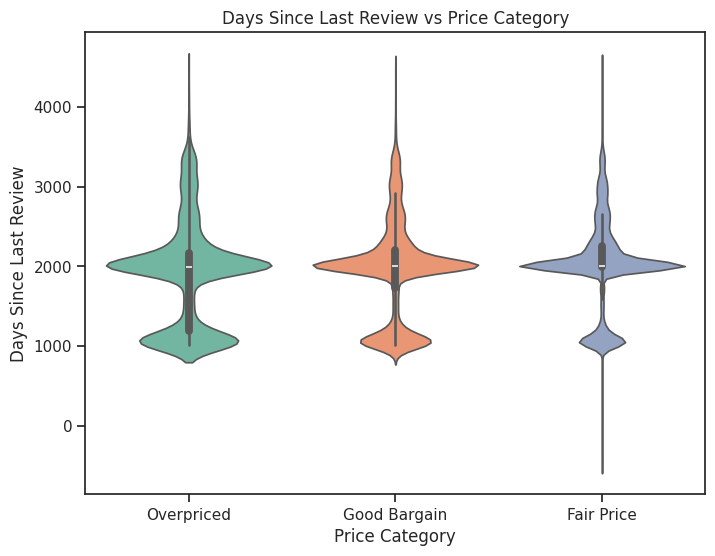

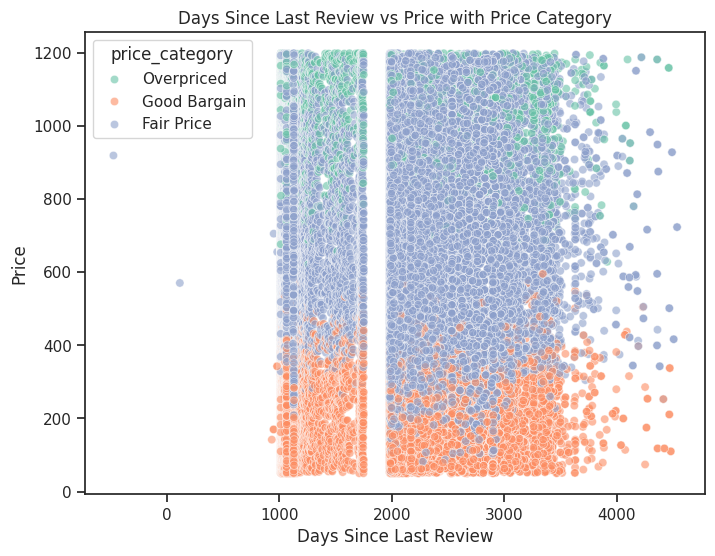

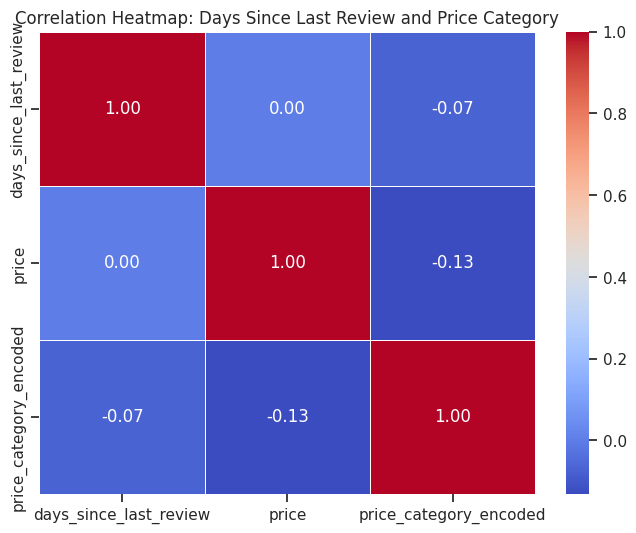

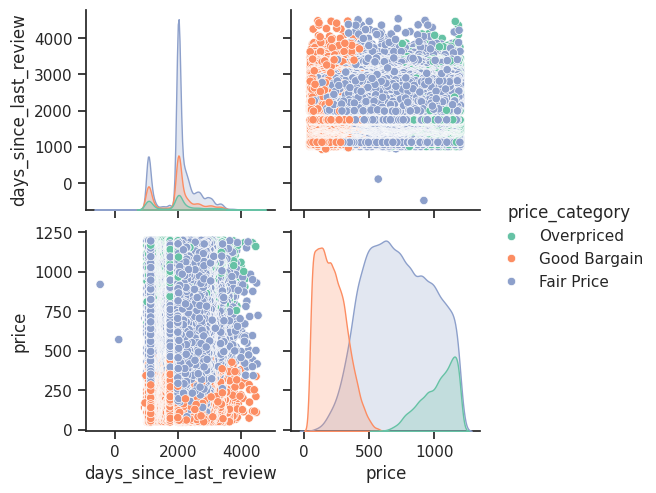

<ipython-input-44-e3fb3bcc7be4>:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price_category', y='days_since_last_review', data=data, palette='Set2')


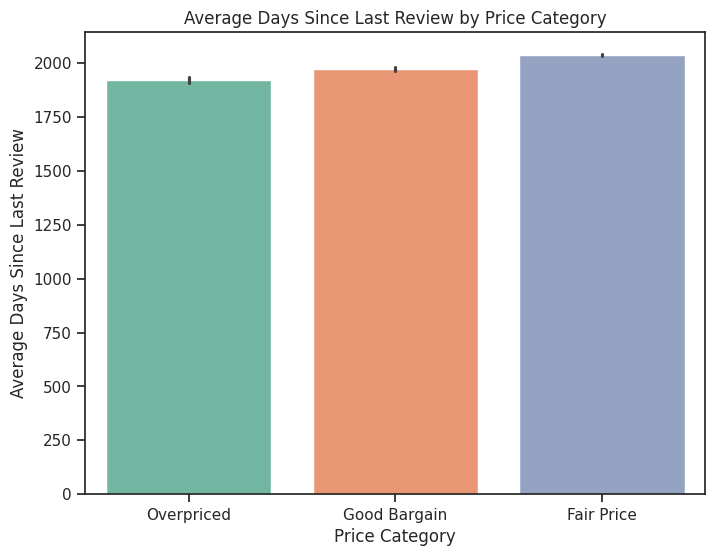

In [ ]:
#Shivam
#do not edit

import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of price_category
plt.figure(figsize=(8, 6))
sns.countplot(x='price_category', data=data, palette='Set2')
plt.title('Distribution of Price Categories')
plt.xlabel('Price Category')
plt.ylabel('Count')
plt.show()
# Scatter plot for price vs price_category
plt.figure(figsize=(8, 6))
sns.boxplot(x='price_category', y='price', data=data, palette='Set2')
plt.title('Price vs Price Category')
plt.xlabel('Price Category')
plt.ylabel('Price')
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(x='neighbourhood_group', y='price', data=data, palette='Set2')
plt.title('Price Distribution by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()
# Boxplot for Price vs Room Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=data, palette='Set2')
plt.title('Price Distribution by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()
plt.figure(figsize=(8, 6))
sns.countplot(x='price_category', hue='instant_bookable', data=data, palette='Set2')
plt.title('Price Category by Instant Bookable')
plt.xlabel('Price Category')
plt.ylabel('Count')
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(x='price_category', y='days_since_last_review', data=data, palette='Set2')
plt.title('Days Since Last Review vs Price Category')
plt.xlabel('Price Category')
plt.ylabel('Days Since Last Review')
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(x='price_category', y='reviews per month', data=data, palette='Set2')
plt.title('Reviews Per Month vs Price Category')
plt.xlabel('Price Category')
plt.ylabel('Reviews Per Month')
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(x='price_category', y='availability 365', data=data, palette='Set2')
plt.title('Availability 365 vs Price Category')
plt.xlabel('Price Category')
plt.ylabel('Availability 365')
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(x='price_category', y='number of reviews', data=data, palette='Set2')
plt.title('Number of Reviews vs Price Category')
plt.xlabel('Price Category')
plt.ylabel('Number of Reviews')
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(x='price_category', y='Construction year', data=data, palette='Set2')
plt.title('Construction Year vs Price Category')
plt.xlabel('Price Category')
plt.ylabel('Construction Year')
plt.show()
plt.figure(figsize=(8, 6))
sns.violinplot(x='price_category', y='days_since_last_review', data=data, palette='Set2')
plt.title('Days Since Last Review vs Price Category')
plt.xlabel('Price Category')
plt.ylabel('Days Since Last Review')
plt.show()
plt.figure(figsize=(8, 6))
sns.scatterplot(x='days_since_last_review', y='price', hue='price_category', data=data, palette='Set2', alpha=0.6)
plt.title('Days Since Last Review vs Price with Price Category')
plt.xlabel('Days Since Last Review')
plt.ylabel('Price')
plt.show()
le = LabelEncoder()
data['price_category_encoded'] = le.fit_transform(data['price_category'])

# Calculate correlation using the encoded column
corr = data[['days_since_last_review', 'price', 'price_category_encoded']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: Days Since Last Review and Price Category')
plt.show()
sns.pairplot(data[['days_since_last_review', 'price', 'price_category']], hue='price_category', palette='Set2')
plt.show()
plt.figure(figsize=(8, 6))
sns.barplot(x='price_category', y='days_since_last_review', data=data, palette='Set2')
plt.title('Average Days Since Last Review by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Average Days Since Last Review')
plt.show()